In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [28]:
#Loading data 
file_path = Path("AAPL.csv")
df = pd.read_csv(file_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0
2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083.0
2019-08-30,52.54,52.61,51.80,52.19,51.67,84573600,0.106096,1005.0


In [29]:
#Dataframe with Adj close, ts_polarity, twitter_volume
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2016-01-04,24.44,0.070389,1133.0
2016-01-05,23.83,0.133635,1430.0
2016-01-06,23.36,0.072042,1949.0
2016-01-07,22.38,0.074369,2289.0
2016-01-08,22.50,0.051595,2235.0


In [30]:
#pct change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

#Drop null values 
df.dropna(inplace=True)
df.head()

,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2016-01-05,23.83,0.133635,1430.0,-0.024959
2016-01-06,23.36,0.072042,1949.0,-0.019723
2016-01-07,22.38,0.074369,2289.0,-0.041952
2016-01-08,22.50,0.051595,2235.0,0.005362
2016-01-11,22.86,0.019443,1222.0,0.016000


In [31]:
#Creation of vectors X and Y 
#X = input features / Y = target vector

def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    #Create empty lists "X_close", "X_polarity",  "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    
    for i in range(len(df) - window):
        
        #Get close, ts_polarity, tw_vol and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        #Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close, X_polarity, X_volume)), np.array(y).reshape(-1, 1)

In [32]:
#Predict closing prices using a 3 day window of previous closing prices
window_size = 3 

#Column index 0 is the "Adj Close" column
#Column index 1 is the "ts_polarity"
#Column index 2 is the "twitter_volume" column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0 
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [33]:
#Use 70% of the data for training and 30% for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

#Set X_train, X_test, y_train, t_test
X_train = X[:X_split]
X_test = X[X_split:]
y_train = y[:y_split]
y_test = y[y_split:]

In [34]:
#Use MinMaxScaler to scale data between 0 and 1
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

#Fit the scaler for the Training data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

#Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

#Fit the scaler for the Test data 
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

#Scale the test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [35]:
#Create the Random Forest Regressor instance
model = RandomForestRegressor(n_estimators=1000, max_depth=2, bootstrap=False, min_samples_leaf=1)

In [36]:
#Fit the model
model.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [37]:
#Make prediction
predicted = model.predict(X_test)

In [38]:
#Evaluation of model
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print("R-squared: ", metrics.r2_score(y_test, predicted))

Root Mean Squared Error:  0.09939090775682667
R-squared:  0.8223693379897365


In [39]:
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [40]:
#Create a dataframe of Real and predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,47.215169
2018-07-30,46.13,47.215169
2018-07-31,46.22,47.215169
2018-08-01,48.95,47.215169
2018-08-02,50.38,47.215169


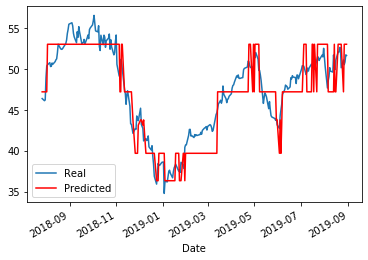

In [41]:
# gca stands for 'get current axis'
ax = plt.gca()

stocks.plot(kind='line',y='Real',ax=ax)
stocks.plot(kind='line',y='Predicted', color='red', ax=ax)

plt.show()
